# Classification

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

The primary goal of this notebook is to review ways to evaluate binary classification algorithms.  We'll start with the confusion matrix and the metrics that are derived from it, including accuracy, sensitivity, specificity, predictive value, false positive rate, and false negative rate.

Then...

## Machine Bias

As an example of a classification problem, I will replicate the analysis reported in
"[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, and published by [ProPublica](https://www.propublica.org), in May 2016.

This article is about a statistical tool called COMPAS which was used by judges in Broward County, Florida, to inform their sentencing decisions, specifically which convicted defendents would be put in prison and which would be released on parole.

COMPAS uses information about the defendants to generate a "risk score" which is intended to quantify the risk that defendant would commit another crime is released.

The authors of the ProPublica article used public data to assess the accuracy of those risk scores.  They explain:

> We obtained the risk scores assigned to more than 7,000 people arrested in Broward County, Florida, in 2013 and 2014 and checked to see how many were charged with new crimes over the next two years, the same benchmark used by the creators of the algorithm.

[In their notebook](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb), they explain in more detail:

> We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
>
> [...]
>
> Next, we sought to determine if a person had been charged with a new crime subsequent to crime for which they were COMPAS screened. We did not count traffic tickets and some municipal ordinance violations as recidivism. We did not count as recidivists people who were arrested for failing to appear at their court hearings, or people who were later charged with a crime that occurred prior to their COMPAS screening.

They use this data to evaluate how well COMPAS predicts the risk that a defendant will be charged with another crime within two years of their release.

Among their findings, they report:

> ... the algorithm was somewhat more accurate than a coin flip. Of those deemed likely to re-offend, 61 percent were arrested for any subsequent crimes within two years.
> 
> ... In forecasting who would re-offend, the algorithm made mistakes with black and white defendants at roughly the same rate but in very different ways.
>
> * The formula was particularly likely to falsely flag black defendants as future criminals, wrongly labeling them this way at almost twice the rate as white defendants.
>
> * White defendants were mislabeled as low risk more often than black defendants.

I'll start by replicating their analysis, and use this example to explain the metrics used to assess binary classification algorithms.

## Data

Thank you to ProPublica and the authors of "Machine Bias" for making their data and analysis freely available.  They are a model of open science.

[This repository](https://github.com/propublica/compas-analysis) the data and analysis pipeline described on [this web page](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [1]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

--2020-03-05 09:30:08--  https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv [following]
--2020-03-05 09:30:13--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.36.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.36.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  11.5MB/s    in 0.2s    

2020-03-05 09:30:18 (11.5 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]

The following cells read the data file and display the column headings.  I have not found documentation for the columns in this dataset, so we'll have to infer what they mean based on the column names and how they are used in the original analysis.

In [62]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

In [71]:
cp.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

Here are the libraries and functions I'll use for my analysis.

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [73]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

## The Confusion Matrix

The authors of "Machine Bias" describe their analysis in more detail in [this article](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).  It includes this table, which summarizes many of the results they report:

<img src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/machine_bias_table.png'>


The table summarizes results for all defendants and two subgroups: defendants classified as white ("Caucasian" in the original dataset) and black ("African-American").

For each group, the summary includes a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) and a number of metrics, including

* FP rate: false positive rate
* FN rate: false negative rate
* PPV: positive predictive value
* NPV: negative predictive value
* LR+: positive likelihood ratio 
* LR-: negative likelihood ratio 

I will explain what these metrics mean and how to compute them, and we'll replicate the results in this table.

But first let's examine the data and compute a couple of recoded variables.

The following function displays the values in a Series and the number of times each value appears.

In [ ]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts(dropna=False).sort_index()

Here are the values of `decile_score` which is the output of the COMPAS algorithm.  `1` is the lowest risk category; `10` is the highest.

In [13]:
values(cp['decile_score'])

1     1440
2      941
3      747
4      769
5      681
6      641
7      592
8      512
9      508
10     383
Name: decile_score, dtype: int64

It's important to note that COMPAS is not a binary classifier; that is, it does no predict that a defendant will or will not recidivate.  Rather, it gives each defendant a score that is intended to reflect the risk that they will recidivate.

In order to evaluate the performance of COMPAS, the authors of the ProPublica article chose a threshold, `4`, and define decile scores at or below the threshold to be "low risk", and scores above the threshold to be "high risk".

The choice of the threshold is arbitrary.  Later, we will see what happens with other choice, but we'll start by replicating the original analysis.

`high_risk` is a Boolean Series that's `True` for respondents with a decile score greater than 4.

In [100]:
high_risk = (cp['decile_score'] > 4)
high_risk.name = 'HighRisk'
values(high_risk)

False    3897
True     3317
Name: HighRisk, dtype: int64

The column `two_year_recid` indicates whether a defendant was charged with another crime during a two year period, after the original charge, when they were not in a correctional facility.

In [101]:
values(cp['two_year_recid'])

0    3963
1    3251
Name: two_year_recid, dtype: int64

`new_charge_2` is a Boolean Series that is `True` for defendants who were charged with another crime within two years.

In [102]:
new_charge_2 = (cp['two_year_recid'] == 1)
new_charge_2.name = 'NewCharge2'
values(new_charge_2)

False    3963
True     3251
Name: NewCharge2, dtype: int64

If we make a cross-tabulation of `new_charge_2` and `high_risk`, the result is a DataFrame that indicates how many defendants are in each of four groups:

In [103]:
pd.crosstab(new_charge_2, high_risk)

HighRisk,False,True
NewCharge2,,
False,2681,1282
True,1216,2035


This table is called a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) or error matrix.  Reading from left to right and top to bottom, the elements of the matrix show the number of respondents who were:

* Classified as low risk and not arrested again: there were 2681 *true negatives*; that is, cases where the test is negative (not high risk) and the prediction turned out to be true (not arrested again).

* High risk and not arrested: there were 1282 *false positives*, cases where the test is positive and the prediction was false.

* Low risk and arrested: there were 1216 *false negatives*, cases where the test is negative (low risk) and the prediction is false (the defendant was arrested again).

* High risk and arrested: there were 2035 *true positives*, cases where the test is positive and the prediction was true.

The values in this matrix are consistent with the values in the ProPublica article, so we can confirm that we are reading the data and replicating their analysis correctly.

In the next section we'll see several ways to use the confusion matrix to quantify the accuracy of the test.

But first let's compute confusion matrices for white and black defendants.

Here are the values of `race`:

In [104]:
values(cp['race'])

African-American    3696
Asian                 32
Caucasian           2454
Hispanic             637
Native American       18
Other                377
Name: race, dtype: int64

Here's a Boolean Series that's true for white defendants.

In [105]:
white = (cp['race'] == 'Caucasian')
white.name = 'white'
values(white)

False    4760
True     2454
Name: white, dtype: int64

And here's the confusion matrix for white defendants.

In [106]:
pd.crosstab(new_charge_2[white], high_risk[white])

HighRisk,False,True
NewCharge2,,
False,1139,349
True,461,505


Again, these results are consistent with the table in the ProPublica article.

`black` is a Boolean Series that is `True` for black defendants.

In [107]:
black = (cp['race'] == 'African-American')
black.name = 'black'
values(black)

False    3518
True     3696
Name: black, dtype: int64

And here is the confusion matrix for black defendants.

In [108]:
pd.crosstab(new_charge_2[black], high_risk[black])

HighRisk,False,True
NewCharge2,,
False,990,805
True,532,1369


Again these results are consistent with the ProPublica article.

## Arranging the confusion matrix

In the previous section I arranged the confusion matrix to be consistent with the ProPublica article, to make it easy to check for consistency.

In general, there are many possible ways to arrange a confusion matrix: you can put the predictions along the columns and the actual conditions along the rows, or the other way around, and you can sort the rows and columns in either order.

There is no universal standard arrangement, but the one that seems to be most common is the one on the [confusion matrix Wikipedia page](https://en.wikipedia.org/wiki/Confusion_matrix), which looks like this:

<img width=400, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/confusion_matrix1.png'>

In this arrangement:

* The predictions are along the rows.

* The actual results are along the columns.

* The rows and columns are sorted so true positives are in the upper left; true negatives are in the lower right.

In the context of the ProPublica article:

* "Predicted condition positive" means the defendant is classified as high risk

* "Predicted condition negative" means low risk.

* "Condition positive" means the defendant was arrested again (recidivated).

* "Condition negative" means they were not arrested (survived).

The following function make a confusion matrix with this arrangement:

In [130]:
def make_matrix(cp, subgroup):
    """Make a confusion matrix.
    
    cp: DataFrame
    subgroup: Boolean Series
    
    returns: DataFrame containing the confusion matrix
    """
    a = np.where(cp['decile_score'] > 4, 'Positive', 'Negative')
    high_risk = pd.Series(a, name='Predicted')
    
    a = np.where(cp['two_year_recid'] == 1, 'Condition', 'No Condition')
    new_charge_2 = pd.Series(a, name='Actual')

    matrix = pd.crosstab(high_risk[subgroup], new_charge_2[subgroup])
    matrix.sort_index(axis=0, ascending=False, inplace=True)
    
    return matrix

Here's the confusion matrix for white defendants.

In [127]:
matrix_white = make_matrix(cp, white)
matrix_white

Actual,Condition,No Condition
Predicted,,
Positive,505,349
Negative,461,1139


In [128]:
matrix_black = make_matrix(cp, black)
matrix_black

Actual,Condition,No Condition
Predicted,,
Positive,1369,805
Negative,532,990


In [129]:
all_defendants = np.ones_like(white)
matrix_all = make_matrix(cp, all_defendants)
matrix_all

Actual,Condition,No Condition
Predicted,,
Positive,2035,1282
Negative,1216,2681


## Metrics

Based on these results, how accurate is COMPAS as a binary classifier?  Well, it turns out that there are a *lot* of ways to answer that question.

One of the simple ones is overall **accuracy** which is the fraction (or percentage) of correct predictions.

To compute accuracy, it is convenient to extract from the confusion matrix the number of true negatives, false positives, false negatives, and true positives.

In [131]:
tp, fp, fn, tn = matrix_all.to_numpy().flatten()

The number of true predictions is `tp + tn`.

The number of false predictions is `fp + fn`.

So we can compute the fraction of true predictions like this:

In [132]:
def percent(x, y):
    """Compute the percentage `x/(x+y)*100`.
    """
    return x / (x+y) * 100

In [133]:
accuracy = percent(tp + tn, fp + fn)
accuracy

65.37288605489326

As a way to evaluate a binary classifier, accuracy does not distinguish between true positives and true negatives, or false positives and false negatives.

But it is often important to make these distinctions, because the benefits of true predictions and true negatives might be different, and the costs of false positives and false negatives might be different.

### Predictive value

One way to make these distinctions is to compute the "predictive value" of positive and negative tests. 

* **Positive predictive value (PPV)**, is the fraction of positive tests that are correct.

* **Negative predictive value (NPV)**, is the fraction of negative tests that are correct.

In this example, PPV is the fraction of high risk defendants who were arrested again.  NPV is the fraction of low risk defendants who were not arrested.

The following function takes a confusion matrix and computes these metrics.

In [134]:
def predictive_value(m):
    """Compute positive and negative predictive value.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

Compute predictive value for all defendants.

In [135]:
ppv, npv = predictive_value(matrix_all)
ppv, npv

(61.350618028338864, 68.79651013600206)

Among all defendants, a negative test result is correct about 69% of the time; a positive test is correct about 61% of the time.

## Sensitivity and specificity

Another way to characterize the accuracy of a test is to compute 

* **Sensitivity**, which is the probability of predicting correctly when the condition is present, and 

* **Specificity**, which is the probability of predicting correctly when the condition is absent.

A test is "sensitive" if it correctly detects the positive condition. 
In this example, sensitivity is the fraction of recidivists who were classified as high risk.

And a test is "specific" if it correctly identifies the negative condition.  In this example, specificity is the fraction of non-recidivists who we classified as low risk.

The following function takes a confusion matrix and computes sensitivity and specificity.

In [136]:
def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    lr_pos = sens / (1 - spec)
    lr_neg = (1 - sens) / spec
    return sens, spec

Here are sensitivity and specificity for all defendants.

In [137]:
sens, spec = sens_spec(matrix_all)
sens, spec

(62.59612426945556, 67.65076961897553)

If we evaluate COMPAS as a binary classifier, it is a little more specific than sensitive:

* About 64% of the recidivists were classified as high risk.

* About 67% of the non-recidivists were classified as low risk.

It can be hard to keep all of these metrics straight, especially when you are learning about them for the first time.  This following diagram from Wikipedia might help:

<img width=800, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/confusion_matrix2.png'>

PPV and sensitivity are similar in the sense that they both have true positives in the numerator.  The difference is the denominator:

* PPV is the ratio of true positives to all positive tests.  So it answers the question, "Of all positive tests, how many are correct?"

* Sensitivity is the ratio of true positives to all positive conditions.  So it answers the question "Of all positive conditions, how many are classified correctly?"

Similary, NPV and sensitivity both have true negatives in the numerator, but:

* NPV is the ratio of true negatives to all negative tests.  It answers, "Of all negative tests, how many are correct?"

* Specificiy is the ratio of true negatives to all negative conditions.  It answers, "Of all negative conditions, how many are classified correctly?"

### False positive and negative rates

The ProPublica article reports PPV and NPV, but instead of sensitivity and specificity, it reports:

* **False positive rate**, which is the ratio of false positives to all negative conditions.  It answers, "Of all negative conditions, how many are misclassified?" 

* **False negative rate**, which is the ratio of false negatives to all positive conditions.  It answers, "Of all positive conditions, how many are misclassified?"

In this example:

* The false positive rate is the fraction of non-recidivists who were classified as high risk.

* The false negative rate is the fraction of recidivists who were classified as low risk.

The following function takes a confusion matrix and computes false positive and false negative rates.

In [138]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

Here are the error rates for all defendants.

In [139]:
fpr, fnr = error_rates(matrix_all)
fpr, fnr

(32.349230381024476, 37.40387573054445)

False positive rate is the complement of specificity, which means they have to add up to 100%

And false negative rate is the complement of sensitivity.

In [144]:
fpr + spec, fnr + sens

(100.0, 100.0)

So FPR and FNR are just another way of reporting sensitivity and specificity.

In general, I think it is better to report sensitivity and specificity, because

* I think the positive framing is easier to interpret than the negative framing, and

* I find it easier to remember what "sensitivity" and "specificity" mean.

I think "false positive rate" and "false negative rate" are more problematic.  For example, "false positive rate" could just as easily mean

1. The fraction of positive tests that are incorrect, or

2. The fraction of negative conditions that are misclassified.

As it happens, the first is the "false discovery rate" and the second is the "false positive rate".

So, here's my recommendation: if you have the choice, generally use PPV, NPV, sensitivity and specificity, and avoid the other metrics.

However, since the ProPublica article uses FPR and FNR, I will too.

They also report LR+ and LR-, but those are just combinations of other metrics and not relevant to the current discussion, so I will ignore them.

However, there is one other metric that I think is relevant, and not included in the ProPublica tables: prevalence, which is the fraction of all cases where the condition is positive.  In the example, it's the fraction of defendants who recidivate.

The following function computes prevalence:

In [146]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = df.to_numpy().flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

And here's the prevalence for all defendants:

In [147]:
prev = prevalence(matrix_all)
prev

45.06515109509287

About 45% of the defendants in this dataset were charged with another crime within two years of their release.

## All metrics

The following function takes a confusion matrix and computes the metrics from the 

In [148]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, prev
    df.index.name = name
    return df

Compute metrics for all defendants.

In [149]:
compute_metrics(matrix_all, 'All defendants')

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


Comparing these results to the table from ProPublica, it looks like our analysis agrees with theirs.

<img src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/machine_bias_table.png'>


We can compute the same metrics for black defendants.

In [150]:
compute_metrics(matrix_black, 'Black defendants')

,Percent
Black defendants,
FP rate,44.846797
FN rate,27.985271
PPV,62.971481
NPV,65.045992
Prevalence,51.433983


And for white defendants.

In [151]:
compute_metrics(matrix_white, 'White defendants')

,Percent
White defendants,
FP rate,23.454301
FN rate,47.722567
PPV,59.133489
NPV,71.187500
Prevalence,39.364303


All of these results are consistent with those reported in the article, including the headline results:

1. The false positive rate for black defendants is substantially higher than for white defendants (45%, compared to 23%).

2. The false negative rate for black defendants is substantially lower (28%, compared to 48%).

In [152]:
error_rates(matrix_black)

(44.84679665738162, 27.985270910047344)

In [153]:
error_rates(matrix_white)

(23.45430107526882, 47.72256728778468)

On the face of it, this looks unfair:

* Of all people who *will* recidivate, black defendants are more likely than white defendants to be classified as high risk, and (if these classifications influence sentencing decisions) more likely to be sent to prison.  

* Of all people who *will not* recidivate, white defendants are less likely than black defendants to be be classified as high risk and sent to prison. 

## AUC

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

## The constant predictive value model

An ideal test should have equal predicitive value in all groups; that is, two people in the same risk category should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk. 

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Speficially, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

The next two sections demonstrate these effects.

A confusion matrix contains four values, but because they are contrained to add up to 100, it only takes 3 values to determine a confusion matrix.

For example, if you specify prevalence, PPV, and NPV, that determines a confusion matrix, and then you can compute the error rates.

Or, if you specify prevalence, FPR, and FNR, that determines a confusion matrix, and then you can compute predictive values.

The following function takes prevalence, PPV, and NPV and returns a confusion matrix.

In [21]:
def constant_predictive_value(prev, ppv, npv):
    """Make a confusion matrix with given metrics.
    
    prev: prevalence
    ppv: positive predictive value
    npv: negative predictive value
    
    returns: confusion matrix
    """
    tn, fp, fn, tp = symbols('tn fp fn tp')
    eq1 = Eq(percent(tp+fn, tn+fp), prev)
    eq2 = Eq(percent(tp, fp), ppv)
    eq3 = Eq(percent(tn,fn), npv)
    eq4 = Eq(tn+fp+fn+tp, 1)
    soln = solve([eq1, eq2, eq3, eq4], [tn, fp, fn, tp])
    a = list(soln.values())
    return make_matrix(a)

To test it, I'll construct a confusion matrix with the actual metrics from all defendents.

In [22]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

m = constant_predictive_value(prev, ppv, npv)

,Low,High
Survived,0.371638480731910,0.177710008317161
Recidivated,0.168561131133906,0.282090379817023


If we use it to compute the other metrics, they are consistent with the results we got with the original data.

In [23]:
compute_metrics(m)

,Percent
,
FP rate,32.3492303810245
FN rate,37.4038757305443
PPV,61.3506180283389
NPV,68.7965101360021
Sensitivity,62.5961242694557
Specificity,67.6507696189755
Prevalence,45.0651510950929


We can use this function to run the "constant predictive value" model, which asks what happens if we keep PPV and NPV constant, and vary prevalence. 

In [24]:
ppv, npv = predictive_value(matrix_all)
prevalences = np.linspace(32, 60, 31)

fp_rates = pd.Series(index=prevalences)
fn_rates = pd.Series(index=prevalences)

for prev in prevalences:
    df = constant_predictive_value(prev, ppv, npv)
    fpr, fnr = error_rates(df)
    fp_rates[prev] = fpr
    fn_rates[prev] = fnr

The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

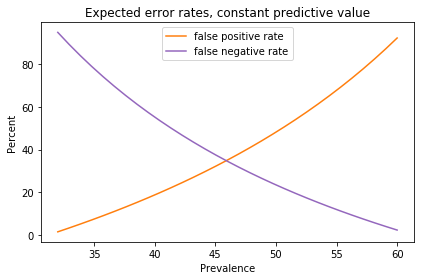

In [25]:
def plot_cpv_model():
    fp_rates.plot(label='false positive rate', color='C1')
    fn_rates.plot(label='false negative rate', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Expected error rates, constant predictive value',
             loc='upper center')
    
plot_cpv_model()

As prevalence increases, false positive rates increase quickly.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant prediction model again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [26]:
def plot_fpr_fnr(m):
    """Plot error rates versus prevalence.
    
    m: confusion matrix
    """
    prev = prevalence(m)
    fpr, fnr = error_rates(m)
    plt.plot(prev, fpr, 'o', color='C1')
    plt.plot(prev, fnr, 'o', color='C4')

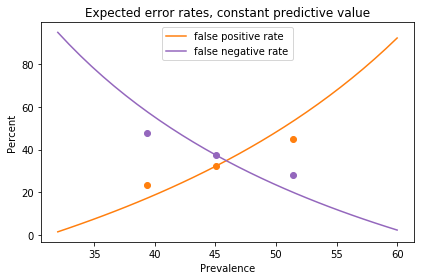

In [27]:
plot_fpr_fnr(matrix_all)
plot_fpr_fnr(matrix_black)
plot_fpr_fnr(matrix_white)

plot_cpv_model()

For black defendants:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For white defendants:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I will call "tempered", that is, less sensitive to variation in prevalence between groups.


## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [28]:
def constant_error_rates(prev, fpr, fnr):
    """Make a confusion matrix with given metrics.
    
    prev: prevalence
    fpr: false positive rate
    fnr: false negative rate
    
    returns: confusion matrix
    """
    tn, fp, fn, tp = symbols('tn fp fn tp')
    eq1 = Eq(percent(tp+fn, tn+fp), prev)
    eq2 = Eq(percent(fp, tn), fpr)
    eq3 = Eq(percent(fn, tp), fnr)
    eq4 = Eq(tn+fp+fn+tp, 1)
    soln = solve([eq1, eq2, eq3, eq4], [tn, fp, fn, tp])
    a = list(soln.values())
    return make_matrix(a)

Again, just to test it, we can replicate the observed confusion matrix.

In [29]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)
m = constant_error_rates(prev, fpr, fnr)

,Low,High
Survived,0.371638480731910,0.177710008317161
Recidivated,0.168561131133907,0.282090379817022


And it has the right metrics

In [30]:
compute_metrics(m)

,Percent
,
FP rate,32.3492303810245
FN rate,37.4038757305445
PPV,61.3506180283388
NPV,68.7965101360020
Sensitivity,62.5961242694555
Specificity,67.6507696189755
Prevalence,45.0651510950929


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [31]:
fpr, fnr = error_rates(matrix_all)
prevalences = np.linspace(20, 70, 31)

ppv_rates = pd.Series(index=prevalences)
npv_rates = pd.Series(index=prevalences)

for prev in prevalences:
    df = constant_error_rates(prev, fpr, fnr)
    ppv, npv = predictive_value(df)
    ppv_rates[prev] = ppv
    npv_rates[prev] = npv

The following function plots the results.

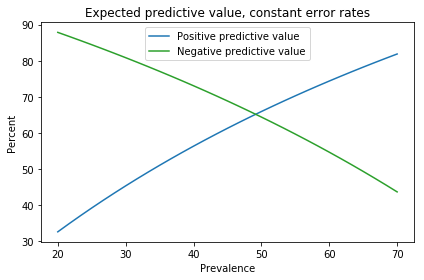

In [32]:
def plot_cer_model():
    ppv_rates.plot(label='Positive predictive value', color='C0')
    npv_rates.plot(label='Negative predictive value', color='C2')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Expected predictive value, constant error rates',
             loc='upper center')
    
plot_cer_model()

As prevalence increases, so does positive predictive value.

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant error rate again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [33]:
def plot_ppv_npv(m):
    """Plot predictive values versus prevalence.
    
    m: confusion matrix
    """
    prev = prevalence(m)
    ppv, npv = predictive_value(m)
    plt.plot(prev, ppv, 'o', color='C0')
    plt.plot(prev, npv, 'o', color='C2')

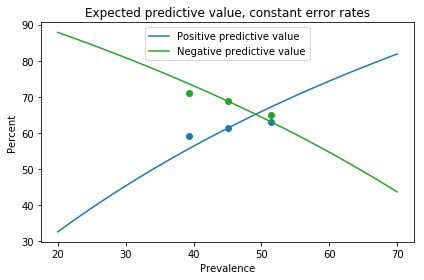

In [34]:
plot_ppv_npv(matrix_all)
plot_ppv_npv(matrix_black)
plot_ppv_npv(matrix_white)

plot_cer_model()

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.

### More data, more details

In this section I read the detailed dataset available from [this repository](https://github.com/propublica/compas-analysis) and run validation checks.

In [35]:
# Uncomment and run this cell once to download the data.
# Then comment it again so you don't download it every time you run the notebook.
# !wget 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

In [36]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [37]:
cp.shape

(7214, 53)

In [38]:
for col in cp.columns:
    print(col)

id
name
first
last
compas_screening_date
sex
dob
age
age_cat
race
juv_fel_count
decile_score
juv_misd_count
juv_other_count
priors_count
days_b_screening_arrest
c_jail_in
c_jail_out
c_case_number
c_offense_date
c_arrest_date
c_days_from_compas
c_charge_degree
c_charge_desc
is_recid
r_case_number
r_charge_degree
r_days_from_arrest
r_offense_date
r_charge_desc
r_jail_in
r_jail_out
violent_recid
is_violent_recid
vr_case_number
vr_charge_degree
vr_offense_date
vr_charge_desc
type_of_assessment
decile_score.1
score_text
screening_date
v_type_of_assessment
v_decile_score
v_score_text
v_screening_date
in_custody
out_custody
priors_count.1
start
end
event
two_year_recid


The following functions compute value counts and percentages for various variables.

In [39]:
def make_dataframe(series, *columns):
    """Make a Series into a DataFrame with one column.
    
    So it looks better in Jupyter.
    
    series: Series
    columns: column name(s)
    
    returns: DataFrame
    """
    df = pd.DataFrame(series.values,
                      index=series.index,
                      columns=columns)
    df.index.name = series.name
    return df

def counts(df, var):
    """Compute counts for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts()
    return make_dataframe(series, 'Count')

def percentages(df, var):
    """Compute percentages for each unique value.
    
    df: DataFrame
    var: variable name
    """
    series = df[var].value_counts() / len(df) * 100
    return make_dataframe(series, 'Percentage')

Breakdown by age

In [40]:
counts(cp, 'age_cat')

,Count
age_cat,
25 - 45,4109
Greater than 45,1576
Less than 25,1529


In [41]:
percentages(cp, 'age_cat')

,Percentage
age_cat,
25 - 45,56.958691
Greater than 45,21.846410
Less than 25,21.194899


Breakdown by race

In [42]:
counts(cp, 'race')

,Count
race,
African-American,3696
Caucasian,2454
Hispanic,637
Other,377
Asian,32
Native American,18


In [43]:
percentages(cp, 'race')

,Percentage
race,
African-American,51.233712
Caucasian,34.017189
Hispanic,8.830053
Other,5.225950
Asian,0.443582
Native American,0.249515


Breakdown by sex

In [44]:
counts(cp, 'sex')

,Count
sex,
Male,5819
Female,1395


In [45]:
percentages(cp, 'sex')

,Percentage
sex,
Male,80.6626
Female,19.3374


Breakdown by recidivism

In [46]:
counts(cp, 'two_year_recid')

,Count
two_year_recid,
0,3963
1,3251


In [47]:
percentages(cp, 'two_year_recid')

,Percentage
two_year_recid,
0,54.934849
1,45.065151


Breakdown by risk category

In [48]:
counts(cp, 'score_text')

,Count
score_text,
Low,3897
Medium,1914
High,1403


In [49]:
percentages(cp, 'score_text')

,Percentage
score_text,
Low,54.019961
Medium,26.531744
High,19.448295


The following function computes cross-tabulations.

In [50]:
def crosstab(df, index, columns):
    """Compute a cross-tabulation.
    
    df: DataFrame
    index: variable(s) that will label the rows
    columns: variable(s) that will label the columns
    
    returns: DataFrame
    """

    xtab = df.pivot_table(index=index, 
                          columns=columns,
                          values='id',
                          aggfunc='count')
    
    return xtab

Breakdown by sex and race

In [51]:
xtab = crosstab(cp, 'sex', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,652,2,567,103,4,67
Male,3044,30,1887,534,14,310


Breakdown by age and race

In [52]:
xtab = crosstab(cp, 'age_cat', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
age_cat,,,,,,
25 - 45,2194,14,1312,367,12,210
Greater than 45,582,11,752,143,3,85
Less than 25,920,7,390,127,3,82


Breakdown by age and sex

In [53]:
xtab = crosstab(cp, 'age_cat', 'sex')

sex,Female,Male
age_cat,,
25 - 45,807,3302
Greater than 45,300,1276
Less than 25,288,1241


Distribution of decile scores for black defendants.

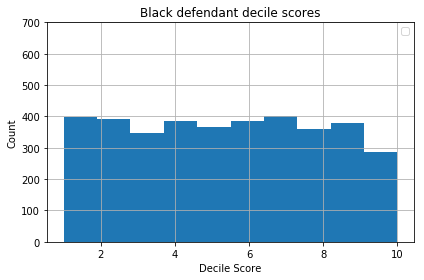

In [54]:
cp.loc[cp.race=='African-American', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='Black defendant decile scores',
         ylim=[0, 700])

Distribution of decile scores for white defendants.

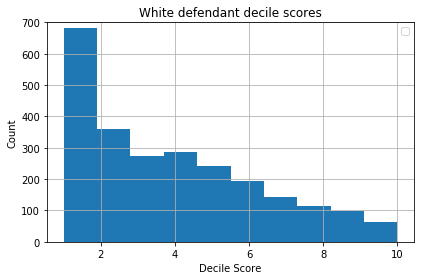

In [55]:
cp.loc[cp.race=='Caucasian', 'decile_score'].hist()
decorate(xlabel='Decile Score',
         ylabel='Count',
         title='White defendant decile scores',
         ylim=[0, 700])

Cross tabulation of decile score and race.

In [56]:
crosstab(cp, 'decile_score', 'race')

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,398.0,15.0,681.0,196.0,NaN,150.0
2,393.0,4.0,361.0,113.0,4.0,66.0
3,346.0,5.0,273.0,86.0,1.0,36.0
4,385.0,NaN,285.0,52.0,1.0,46.0
5,365.0,1.0,241.0,52.0,NaN,22.0
6,384.0,3.0,194.0,37.0,2.0,21.0
7,400.0,1.0,143.0,34.0,4.0,10.0
8,359.0,2.0,114.0,26.0,1.0,10.0
9,380.0,NaN,98.0,20.0,2.0,8.0


Cross tabulation of decile score and age group.

In [57]:
crosstab(cp, 'decile_score', 'age_cat')

age_cat,25 - 45,Greater than 45,Less than 25
decile_score,,,
1,654,782,4
2,660,182,99
3,437,120,190
4,434,98,237
5,405,85,191
6,357,104,180
7,340,77,175
8,298,57,157
9,292,54,162


Here's the confusion matrix with all three score categories.

In [58]:
crosstab(cp, 'two_year_recid', 'score_text')

score_text,High,Low,Medium
two_year_recid,,,
0,402,2681,880
1,1001,1216,1034


To make sure I've got the data right, I'll reproduce the confusion matrices from the article.

In [59]:
def compute_matrix(df):
    """Compute a confusion matrix from data.
    
    df: DataFrame
    
    returns: confusion matrix
    """
    high = cp.score_text.isin(['Medium', 'High']).astype(int)
    return crosstab(df, 'two_year_recid', high)

All defendants.

In [60]:
compute_matrix(cp)

score_text,0,1
two_year_recid,,
0,2681,1282
1,1216,2035


And the differences are 0.

In [61]:
matrix_all - compute_matrix(cp).values

,Low,High
Survived,0,0
Recidivated,0,0


Black defendants.

In [62]:
black = cp[cp.race=='African-American']
compute_matrix(black)

score_text,0,1
two_year_recid,,
0,990,805
1,532,1369


In [63]:
matrix_black - compute_matrix(black).values

,Low,High
Survived,0,0
Recidivated,0,0


White defendants.

In [64]:
white = cp[cp.race=='Caucasian']
compute_matrix(white)

score_text,0,1
two_year_recid,,
0,1139,349
1,461,505


In [65]:
matrix_white - compute_matrix(white).values

,Low,High
Survived,0,0
Recidivated,0,0


### Calibration

To check for calibration, I group defendents by decile score and compute prevalence (recidivism rate) in each group.

This analysis does not take observation time into account, unlike the analysis in the original article.

The following function groups defendants by decile score and computes prevalence in each group.

In [66]:
def calibration_curve(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    return df.groupby('decile_score').two_year_recid.mean()

The following figure shows this calibration curve for all defendants and broken down by race.

In [67]:
def plot_calibration(df, group_vars, title=''):
    calibration_curve(cp).plot(linestyle='dotted',
                        label='All defendants', color='gray')

    for name, group in cp.groupby(group_vars):
        if len(group) > 1000:
            calibration_curve(group).plot(label=name)

    decorate(xlabel='Decile score',
             ylabel='Prob recidivism',
             title=title)

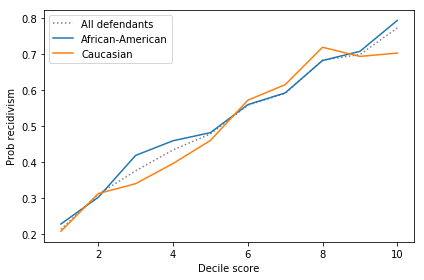

In [68]:
plot_calibration(cp, 'race')

The test is well calibrated.  People with higher scores have higher probabilities of recidivism.  In fact, we could use this curve to transform COMPAS scores into probabilities.

The test is about equally calibrated for black and white defendants, although black defendants with scores 3 and 4 are more likely to recidivate than white defendants with the same scores (that apparent difference might not be statistically significant).

Here's the breakdown by age group.

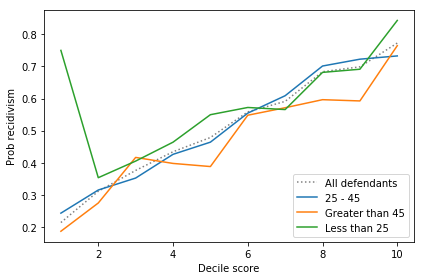

In [69]:
plot_calibration(cp, 'age_cat')
plt.savefig('age_cat.png')

The test is about equally calibrated for all age groups, which means that people with the same score have about the same probability of recidivism, regardless of what group they are in.

There are only 4 people in the "Less than 25" group with decile score 1, which is why that data point is so out of line.

Here's the breakdown by sex.

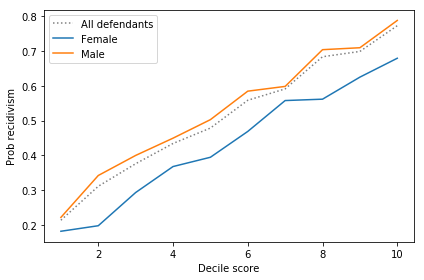

In [72]:
plot_calibration(cp, 'sex')
plt.savefig('sex_cat.png')

Here's the first case where the test does not seem well calibrated.  At all decile scores, female defendants are substantially less likely to recidivate than male defendants.

Or, reading this graph the other way, female defendants are given decile scores 1-2 points higher than male defendants with the same actual risk of recidivism. 

In [71]:
stop


NameError: name 'stop' is not defined

### Comparing reality to the CPV model

In this section I'll compare actual PPV and FPR for a variety of subgroups to the values we would expect based on the CPV model; that is, a model where the predictive values are the same for all groups.

The following function groups defendants by `group_vars` and returns a table with one row for each group.

In [ ]:
def make_table(df, group_vars, expected_ppv, expected_npv):
    """Make a table with one line per group.
    
    df: DataFrame
    group_vars: string or list of string variable names
    expected_ppv: 
    expected_npv:
    
    returns: table
    """
    # make the DataFrame
    columns = ['count', 'prevalence',
               'actual PPV', 'actual NPV', 'actual FNR',
               'actual FPR', 'expected FPR', 'difference']
    columns = group_vars + columns 

    table = pd.DataFrame(columns=columns)

    # loop through the groups
    grouped = df.groupby(group_vars)
    for i, (name, group) in enumerate(grouped):
        if not isinstance(name, tuple):
            name = name,
        
        # size of group
        count = len(group)
        
        # compute metrics
        matrix = compute_matrix(group)
        prev = prevalence(matrix)
        actual_ppv, actual_npv = predictive_value(matrix)
        actual_fpr, actual_fnr = error_rates(matrix)

        # generate the CPV matrix
        cpv = constant_predictive_value(prev, 
                          expected_ppv, expected_npv)

        # get the expected error rates
        expected_fpr, _ = error_rates(cpv * 100)
        
        # for very low and high prevalences, it might
        # not be possible to achieve given predictive values
        if expected_fpr < 0:
            expected_fpr = 0

        if expected_fpr > 100:
            expected_fpr = 100

        # difference between actual and expected
        diff = actual_fpr - expected_fpr

        # add a row to the table
        row = name + (count, prev,
                      actual_ppv, actual_npv, actual_fnr,
                      actual_fpr, expected_fpr, diff)
        
        table.loc[i] = row
        
    # sort the table by prevalence
    table.sort_values(by='prevalence', inplace=True)
    return table

In [ ]:
subset = cp[cp.race.isin(['African-American', 'Caucasian'])]
subset.shape

Here's the breakdown by age category.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat']
table1 = make_table(subset, group_vars, ppv, npv)

Again, the actual behavior of the test is tempered, compare to the CPV model; that is, the results are less extreme than the model expects.

Here's the breakdown by race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race']
table2 = make_table(subset, group_vars, ppv, npv)

The false positive rate for whites is higher than we would expect if predictive value were the same for all groups.

The false positive rate for blacks is lower than we would expect.

Here's the breakdown by sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['sex']
table3 = make_table(subset, group_vars, ppv, npv)

The false positive rate for women is substantially higher than what we would expect in the CPV model, which is consistent with the calibration results in the previous section.

Here's the breakdown by age and race.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race']
table4 = make_table(subset, group_vars, ppv, npv)

Breakdown by age and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'sex']
table5 = make_table(subset, group_vars, ppv, npv)

Breakdown by race and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['race', 'sex']
table6 = make_table(subset, group_vars, ppv, npv)

Breakdown by age, race, and sex.

In [ ]:
ppv, npv = predictive_value(matrix_all)
group_vars = ['age_cat', 'race', 'sex']
table7 = make_table(subset, group_vars, ppv, npv)

Those are all the possible subgroups for these three variables.

Now we can see what the results look like.

In [ ]:
tables = [table1, table2, table3, table4, table5, table6, table7];

The following function plots one data point per subgroup showing the given metric versus prevalence.

Groups with a small number of people are shown with lighter colors.


In [ ]:
def plot_table_var(table, var, color):
    """Plot one data point per row.
    
    table: DataFrame
    var: which metric to plot
    color: string
    """
    for _, row in table.iterrows():
        alpha = 0.8 if row['count'] > 200 else 0.3

        plt.plot(row['prevalence'], row[var],
                 'o', color=color, alpha=alpha)

Here's what the results look like for FPR.

In [ ]:
fp_rates.plot(label='Expected FPR, constant CPV',
              color='C1')
plt.axhline(fpr, linestyle='dotted', 
            label='Expected FPR, constant FPR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FPR', 'C1')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False positive rates by subgroup')

In general, groups with higher prevalence have higher false positive rates, but the effect is less extreme than what we would expect from the CPV model.

Here are the results for positive predictive value.

In [ ]:
ppv_rates.plot(label='Expected PPV, constant FPR', color='C0')
plt.axhline(ppv, linestyle='dotted', 
            label='Expected PPV, constant PPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual PPV', 'C0')
    
decorate(xlabel='Prevalence',
         ylabel='Rate',
         title='Positive predictive value by subgroup')

Groups with higher prevalence have higher PPV, but the effect is less extreme than we would expect from the CPV model.

Here are the results for false negative rate.

In [ ]:
fn_rates.plot(label='Expected FNR, constant CPV',
              color='C4')
plt.axhline(fnr, linestyle='dotted', 
            label='Expected FNR, constant FNR', color='gray')

for table in tables:
    plot_table_var(table, 'actual FNR', 'C4')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='False negative rates by subgroup')

Groups with higher prevalence have lower FNR, but the effect is less extreme than we would expect from the CPV model.

Here are the results for negative predictive value.

In [ ]:
npv_rates.plot(label='Expected NPV, constant FPR', color='C2')
plt.axhline(npv, linestyle='dotted', 
            label='Expected NPV, constant NPV', color='gray')

for table in tables:
    plot_table_var(table, 'actual NPV', 'C2')
    
decorate(xlabel='Prevalence',
         ylabel='Percent',
         title='Negative predictive value by subgroup')

Groups with higher prevalence have lower NPV.  In this case, the effect is almost exactly what we would expect from the CPV model.

### Individual FPR

In [ ]:
from scipy.interpolate import interp1d

def crossing(series, value, **options):
    """Find where a function crosses a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.values, series.index, **options)
    return interp(value)

def interpolate(series, value, **options):
    """Evaluate a function at a value.
    
    series: Series
    value: number
    options: passed to interp1d (default is linear interp)
    
    returns: number
    """
    interp = interp1d(series.index, series.values, **options)
    return interp(value)

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
crossing(cal_all, 0.4)

In [ ]:
crossing(cal_all, 0.7)

In [ ]:
interpolate(cal_all, 3.4)

In [ ]:
interpolate(cal_all, 9)

In [ ]:
def make_error_dist(std_dev):
    """Make a discrete Gaussian distribution.
    
    std_dev: standard deviation
    
    returns: Series that maps errors to probabilities
    """
    errors = np.linspace(-3, 3, 21)
    prob_error = np.exp(-(errors/std_dev)**2)
    prob_error /= np.sum(prob_error)
    error_dist = pd.Series(prob_error, index=errors)
    return error_dist

In [ ]:
error_dist = make_error_dist(std_dev=2)
error_dist.plot(label='')
decorate(xlabel='Error (score)',
         ylabel='Probability')

In [ ]:
def individual_fpr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'not low' | error
        prob_positive = 0 if score < thresh else 1

        # probability of being a false positive | error
        prob_fp = prob_positive * (1-actual_prob_recid)
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fpr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fpr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fpr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FPR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fpr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fpr = individual_fpr(prob_recid, cal, thresh, std_dev)
        prob_fpr_series[prob_recid] = fpr
    return prob_fpr_series

In [ ]:
s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = compute_fpr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false positive')

In [ ]:
def individual_fpr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FPR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FPR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifpr = individual_fpr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifpr
    return total_prob

In [ ]:
individual_fpr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifpr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fpr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifpr_series = pd.Series(t, scores)
    return ifpr_series

In [ ]:
thresh = 4.5

s = make_ifpr_series(cal_all, thresh, std_dev=2)
s.plot(label='FPR, std_dev=2')

s = make_ifpr_series(cal_all, thresh, std_dev=1)
s.plot(label='FPR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
def assign_individual_fpr(df, cal, thresh, std_dev):
    """Assign individual FPRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifpr_series = make_ifpr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifpr'] = [ifpr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_cdf(series):
    """Make a CDF."""
    counts = series.value_counts().sort_index()
    counts /= counts.sum()
    return counts.cumsum()

def plot_cdf(cdf, **options):
    """Plot a CDF as a step function."""
    plt.step(cdf.index, cdf.values, where='post', **options)

In [ ]:
cdf_ifpr = make_cdf(cp.ifpr)

In [ ]:
plot_cdf(cdf_ifpr, label='All')

decorate(xlabel='Individual probability of false positive', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
black = cp[cp.race=='African-American']
white = cp[cp.race=='Caucasian']

thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifpr_series(cal_black, thresh, std_dev)
s.plot(label='FPR, black')

cal_white = calibration_curve(white)
s = make_ifpr_series(cal_white, thresh, std_dev)
s.plot(label='FPR, white')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
male = cp[cp.sex=='Male']
female = cp[cp.sex=='Female']

thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifpr_series(cal_male, thresh, std_dev)
s.plot(label='FPR, male')

cal_female = calibration_curve(female)
s = make_ifpr_series(cal_female, thresh, std_dev)
s.plot(label='FPR, female')

decorate(xlabel='Score',
         ylabel='Probability of false positive')

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

In [ ]:
assign_individual_fpr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifpr.mean()

In [ ]:
cp.groupby('race').ifpr.mean()

### Individual FNR

In [ ]:
cal_all = calibration_curve(cp)
cal_all.plot()
decorate(ylabel='Probability of recidivism')

In [ ]:
def individual_fnr(actual_prob_recid, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_prob_recid: actual probability of recidivism
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # look up actual_prob_recid to get correct score
    correct_score = crossing(cal, actual_prob_recid)

    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # hypothetical score
        score = correct_score+error
        score = max(score, 1)
        score = min(score, 10)
        
        # probability of being classified 'low' | error
        prob_negative = 0 if score >= thresh else 1

        # probability of being a false negative | error
        prob_fp = prob_negative * actual_prob_recid
        
        total_prob += prob_error * prob_fp
    return total_prob

In [ ]:
individual_fnr(0.3, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.5, cal_all, 4.5, 2)

In [ ]:
individual_fnr(0.7, cal_all, 4.5, 2)

In [ ]:
def compute_fnr_vs_prob_recid(cal, thresh, std_dev):
    """Computes FNR as a function of probability of recidivism.
    
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and not low risk
    std_dev: standard deviation of the error function
    
    returns: Series
    """
    prob_recid_array = np.linspace(min(cal), max(cal), 21)
    prob_fnr_series = pd.Series(index=prob_recid_array)
    for prob_recid in prob_recid_array:
        fnr = individual_fnr(prob_recid, cal, thresh, std_dev)
        prob_fnr_series[prob_recid] = fnr
    return prob_fnr_series

In [ ]:
s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = compute_fnr_vs_prob_recid(cal_all, thresh=4.5, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Actual probability of recidivism',
         ylabel='Probability of false negative')

In [ ]:
def individual_fnr_given_score(actual_score, cal, thresh, std_dev):
    """Compute an individual FNR.
    
    actual_score: score assigned
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    
    returns: individual FNR
    """
    # make the error distribution
    error_dist = make_error_dist(std_dev)

    # loop through possible errors
    total_prob = 0
    for error, prob_error in error_dist.iteritems():
        # correct score
        correct_score = actual_score-error
        correct_score = max(correct_score, 1)
        correct_score = min(correct_score, 10)
        
        # map from correct score to probability of recidivism.
        # if calibration curves are different for different
        # groups, this one should be group specific.
        correct_prob_recid = interpolate(cal, correct_score)
        cond_ifnr = individual_fnr(correct_prob_recid,
                                   cal, thresh, std_dev)
        
        total_prob += prob_error * cond_ifnr
    return total_prob

In [ ]:
individual_fnr_given_score(6, cal_all, thresh=4.5, std_dev=2)

In [ ]:
def make_ifnr_series(cal, thresh, std_dev):

    scores = np.arange(1, 11)
    t = [individual_fnr_given_score(score, cal, thresh, std_dev)
         for score in scores]
    
    ifnr_series = pd.Series(t, scores)
    return ifnr_series

In [ ]:
thresh = 4.5

s = make_ifnr_series(cal_all, thresh, std_dev=2)
s.plot(label='FNR, std_dev=2')

s = make_ifnr_series(cal_all, thresh, std_dev=1)
s.plot(label='FNR, std_dev=1')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
def assign_individual_fnr(df, cal, thresh, std_dev):
    """Assign individual FNRs to defendants.
    
    df: DataFrame
    cal: calibration curve, map from score to prob_recid
    thresh: threshold between low and high risk
    std_dev: standard deviation of the error function
    """
    # compute the map from score to FPR
    ifnr_series = make_ifnr_series(cal, thresh, std_dev)
    
    # assign FPR to each defendant
    df['ifnr'] = [ifnr_series[score] for score in df.decile_score]

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)

In [ ]:
cdf_ifnr = make_cdf(cp.ifnr)

In [ ]:
plot_cdf(cdf_ifnr, label='All')

decorate(xlabel='Individual probability of false negative', 
         ylabel='CDF',
         ylim=[0,1])

In [ ]:
thresh = 4.5
std_dev = 2

cal_black = calibration_curve(black)
s = make_ifnr_series(cal_black, thresh, std_dev)
s.plot(label='FNR, black')

cal_white = calibration_curve(white)
s = make_ifnr_series(cal_white, thresh, std_dev)
s.plot(label='FNR, white')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
thresh = 4.5
std_dev = 2

cal_male = calibration_curve(male)
s = make_ifnr_series(cal_male, thresh, std_dev)
s.plot(label='FNR, male')

cal_female = calibration_curve(female)
s = make_ifnr_series(cal_female, thresh, std_dev)
s.plot(label='FNR, female')

decorate(xlabel='Score',
         ylabel='Probability of false negative')

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=2)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=1)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

In [ ]:
assign_individual_fnr(cp, cal_all, thresh=4.5, std_dev=0.01)
cp.ifnr.mean()

In [ ]:
cp.groupby('race').ifnr.mean()

### What would it take?

In this section I explore what it would take to make a test with the same false positive rate for all groups.

In [ ]:
def fpr_thresh(df, thresh):
    df = df.copy()
    df['high'] = df.decile_score >= thresh
    matrix_all = crosstab(df, 'two_year_recid', 'high')
    fpr, fnr = error_rates(matrix_all)
    return fpr

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(white, 5)

In [ ]:
def sweep_thresh(df):
    threshes = range(2,10)
    sweep = pd.Series(index=threshes)
    for thresh in threshes:
        sweep[thresh] = fpr_thresh(df, thresh)
        
    return sweep

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(cp).plot(label='All')
sweep_thresh(black).plot(label='Black')
sweep_thresh(white).plot(label='White')
decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
def find_threshold(group, fpr):
    series = sweep_thresh(group)
    xs = crossing(series.dropna(), fpr)
    return xs

In [ ]:
all_thresh = find_threshold(cp, 32.35)

In [ ]:
black_thresh = find_threshold(black, 32.35)

In [ ]:
white_thresh = find_threshold(white, 32.35)

In [ ]:
interpolate(calibration_curve(cp), all_thresh)

In [ ]:
interpolate(calibration_curve(cp), black_thresh)

In [ ]:
interpolate(calibration_curve(black), black_thresh)

In [ ]:
interpolate(calibration_curve(cp), white_thresh)

In [ ]:
interpolate(calibration_curve(white), white_thresh)

In [ ]:
black_male = black[black.sex=='Male']
black_male.shape

In [ ]:
black_female = black[black.sex=='Female']
black_female.shape

In [ ]:
old_black_female = black_female[black_female.age_cat=='Greater than 45']
old_black_female.shape

In [ ]:
old_white_female = cp[(cp.age_cat=='Greater than 45') &
                      (cp.sex=='Female') &
                      (cp.race=='Caucasian')]
old_white_female.shape

In [ ]:
young_black_male = cp[(cp.age_cat=='Less than 25') &
                      (cp.sex=='Male') &
                      (cp.race=='African-American')]
young_black_male.shape

In [ ]:
fpr_thresh(cp, 5)

In [ ]:
fpr_thresh(black, 5)

In [ ]:
fpr_thresh(black_female, 5)

In [ ]:
fpr_thresh(old_black_female, 5)

In [ ]:
fpr_thresh(black_male, 5)

In [ ]:
fpr_thresh(young_black_male, 5)

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_male).plot(label='Black male')
sweep_thresh(young_black_male).plot(label='Young black male')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
plt.axhline(32.25, color='gray')
sweep_thresh(black).plot(label='Black', color='gray')
sweep_thresh(black_female).plot(label='Black female')
sweep_thresh(old_black_female).plot(label='Old black female')

decorate(xlabel='Threshold',
         ylabel='False positive rate')

In [ ]:
ybm_thresh = find_threshold(young_black_male, 32.35)

In [ ]:
obf_thresh = find_threshold(old_black_female, 32.35)

In [ ]:
interpolate(calibration_curve(cp), ybm_thresh)

In [ ]:
interpolate(calibration_curve(cp), obf_thresh)